In [51]:
# Library imports
import os
import preprocessing
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.io as pio
import plotly.offline as py
import plotly.graph_objs as go
from Twitter_data import *
from Data_scraping_v2 import *
py.init_notebook_mode(connected=True)
pd.options.mode.chained_assignment = None  # default='warn'

# Get datasets from preprocessing
training = preprocessing.get_training_set()
test = preprocessing.get_test_set()
hh_char = preprocessing.INECDataSet('household_characteristics').get_dataset()
education = preprocessing.INECDataSet('edu').get_dataset()
edu_level = preprocessing.INECDataSet('edu_lvl').get_dataset()

# Verify successful load of datasets
assert not training.empty
assert not test.empty
assert not hh_char.empty
assert not education.empty
assert not edu_level.empty



Start to load data...
Processing... Please wait...
Start to load data...
Start to load data...


In [60]:
# Matplotlib plotting setting
SMALL_SIZE = 15
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
grp = training.groupby('Target')
g1 = grp.get_group(1)
g2 = grp.get_group(2)
g3 = grp.get_group(3)
g4 = grp.get_group(4)

In [4]:
avg_child = [ig['hogar_nin'].sum()/ig.shape[0] for ig in [g1,g2,g3,g4]]
avg_adult = [ig['hogar_adul'].sum()/ig.shape[0] for ig in [g1,g2,g3,g4]]
children = go.Bar(
    x=[1, 2, 3, 4],
    y=avg_child,
    name='Children'
)
adult = go.Bar(
    x=[1, 2, 3, 4],
    y=avg_adult,
    name='Adults'
)

layout = go.Layout(
    xaxis={'title': 'Income Group'},
    yaxis={'title': 'Average number per household'},
    barmode='stack'
)

fig = go.Figure(data=[children,adult], layout=layout)#, layout=layout)
py.iplot(fig)

# Household income

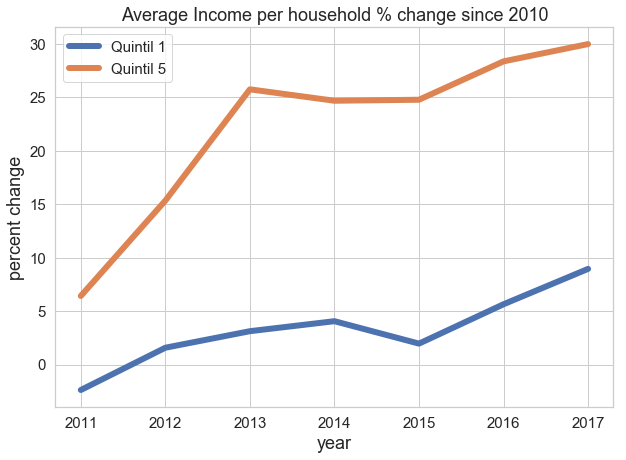

In [61]:
def get_region(df, region_col_name, regions_to_get):
    """
    Given a pandas DataFrame, get the <regions_to_get> from <region_col_name>. Return the result as a DataFrame
    :param df: Pandas DataFrame to work on
    :type df: Pandas DataFrame
    :param region_col_name: Name of the column to get region from
    :type region_col_name: str
    :param regions_to_get: List of regions to get from df
    :type regions_to_get: List of str
    """
    assert isinstance(df, pd.core.frame.DataFrame)
    assert not df.empty
    assert isinstance(region_col_name, str)
    assert region_col_name in df.columns, f'{region_col_name} not in dataframe columns'
    region_grp = df.groupby(region_col_name)
    assert [region in region_grp.groups.keys() for region in regions_to_get], '{regions_to_get} not found in column {region_col_name}!'
    
    region_df = pd.concat([region_grp.get_group(region_name) for region_name in regions_to_get])
    assert not region_df.empty
    return region_df

average_income_household = get_region(hh_char, 'Category', ['Income per household', 'Average income per household',
                                                           'Average total household income'])
average_income_household_person = get_region(hh_char, 'Category', ['Per capita income per household',
                                                                  'Average household income per capita'])
average_income_household.loc[:,['Total', 'Quintil 1', 'Quintil 2', 'Quintil 3', 'Quintil 4', 'Quintil 5']] = average_income_household.loc[:,['Total', 'Quintil 1', 'Quintil 2', 'Quintil 3', 'Quintil 4', 'Quintil 5']].astype(float)
average_income_household_person.loc[:,['Total', 'Quintil 1', 'Quintil 2', 'Quintil 3', 'Quintil 4', 'Quintil 5']] = average_income_household_person.loc[:,['Total', 'Quintil 1', 'Quintil 2', 'Quintil 3', 'Quintil 4', 'Quintil 5']].astype(float)

cr_avg_income_pct_change = get_region(average_income_household, 'region', ['Whole Costa Rica']).set_index('year').drop(['Category','region'],axis=1)
for year in range(2011,2018):
    cr_avg_income_pct_change.loc[year,:] = (cr_avg_income_pct_change.loc[year,:] / cr_avg_income_pct_change.loc[2010,:] - 1) * 100

cr_avg_income_pct_change = cr_avg_income_pct_change.drop(2010)
fig, ax = plt.subplots(figsize=(10,7))
cr_avg_income_pct_change['Quintil 1'].plot.line(ax=ax, lw=6)
cr_avg_income_pct_change['Quintil 5'].plot.line(ax=ax, lw=6)
ax.set_title('Average Income per household % change since 2010', fontsize=18)
ax.legend(labels=['Quintil 1', 'Quintil 5'])
ax.set_ylabel('percent change');
plt.savefig(os.getcwd() + '/plots/Income percent change quintil.png')
    

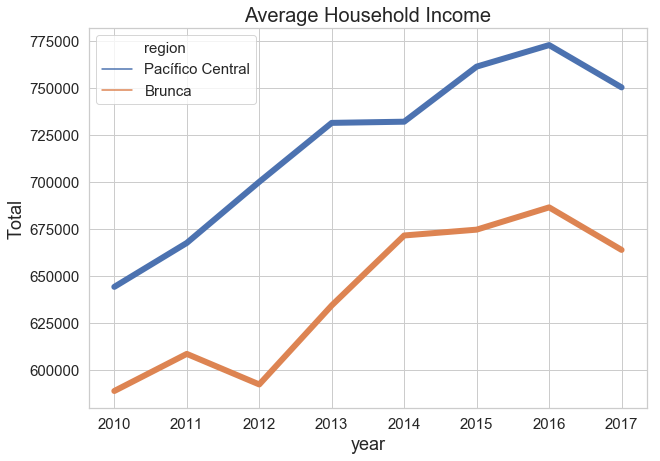

In [62]:
#sns.boxplot(x = 'year', y = 'Total' , data = average_income_household)
c_average_income_household = average_income_household.copy()

c_average_income_household = c_average_income_household.loc[(c_average_income_household['region'] == 'Pacífico Central')|
                                                            ((c_average_income_household['region'] == 'Brunca')),:]
c_average_income_household_person = average_income_household_person.copy()
c_average_income_household_person = c_average_income_household_person.loc[(c_average_income_household_person['region'] == 'Pacífico Central')|
                                                            ((c_average_income_household_person['region'] == 'Brunca')),:]

fig, ax = plt.subplots(figsize = (10, 7))
sns.lineplot(x="year", y="Total", hue="region" ,data = c_average_income_household, ax=ax, lw=6)
ax.set_title('Average Household Income', fontsize=20)
plt.savefig(os.getcwd() + '/plots/Avg_Income_Parallel_1.png');

## Different regions lead by same government
Costa rica is divided into 6 regions by social economic parameter, however, administratively, it is divided into 7 provinces, each lead by a individual government. Interestingly, we obsere that `Pacifico Central` and `Brunca`, two different regions, are actually in the same province administratively, which means they are governed by the same government. As a result, we plotted the average household income per person over the year in those two provinces, and they do look parallel.

`We can conclude that the government has a big role to play to overcome poverty in Costa Rica!`

<img src="https://image.slidesharecdn.com/sociales-151013022512-lva1-app6891/95/resumen-estudios-sociales-de-regiones-de-costa-rica-1-638.jpg?cb=1444704104" alt="drawing" style="width:400px;"/>
<img src="https://www.creescapes.com/wp-content/uploads/costa-rica-map.png" alt="drawing" style="width:400px;"/>

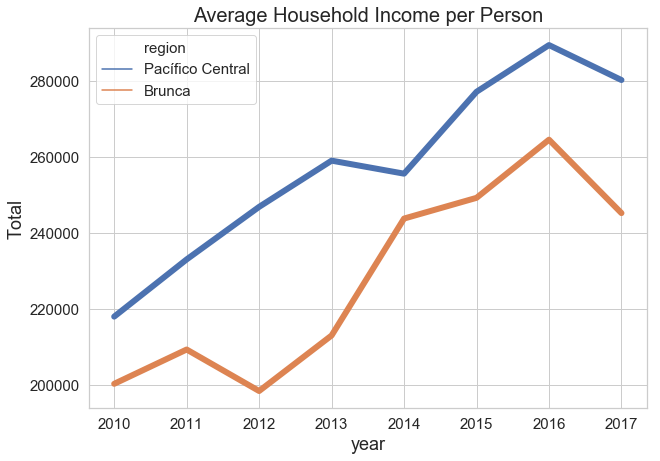

In [63]:
fig, ax = plt.subplots(figsize = (10, 7))
sns.lineplot(x="year", y="Total", hue="region" ,data = c_average_income_household_person, ax=ax, lw=6)
ax.set_title('Average Household Income per Person', fontsize = 20)
plt.savefig(os.getcwd() + '/plots/Avg_Income_Parallel_2.png')

# Overcrowding: Number of person per room

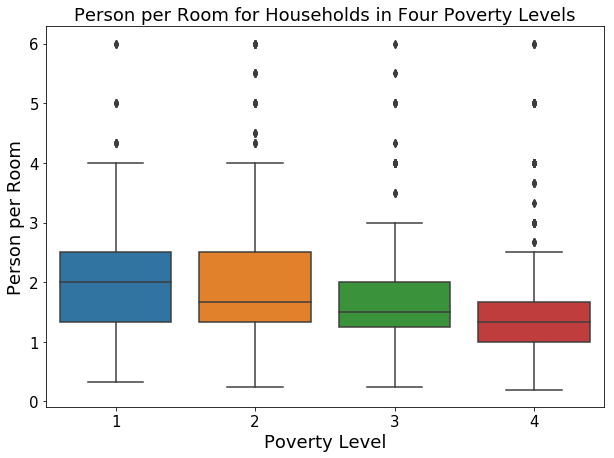

In [9]:
fig, ax = plt.subplots(figsize=[10,7])
sns.boxplot(x='Target', y='overcrowding', data=training, ax=ax)
ax.set_ylabel('Person per Room')
ax.set_xlabel('Poverty Level')
ax.set_title('Person per Room for Households in Four Poverty Levels', fontsize=18)
plt.savefig(os.getcwd() + '/plots/household_overcrowding.png')

In [12]:
year = list(range(2010,2018))
pov = [21.2, 21.7, 20.6, 20.7, 22.4, 21.7, 20.5, 20.0]
poverty_old = go.Scatter(
    x = year[:5],
    y = pov[:5],
    mode = 'lines+markers',
    name = '% Poverty',
    line = dict(width = 4)
)
layout = go.Layout(
    width=500,
    height=500,
    xaxis=dict(title='Year'),
    yaxis=dict(title='Total poverty %'),
    title='Costa Rica Total Poverty % under Laura Chinchilla',
    titlefont=dict(size=14))

fig = go.Figure(data=[poverty_old], layout=layout)
py.iplot(fig)

In [13]:
year = list(range(2010,2018))
pov = [21.2, 21.7, 20.6, 20.7, 22.4, 21.7, 20.5, 20.0]
poverty_new = go.Scatter(
    x = year[4:],
    y = pov[4:],
    mode = 'lines+markers',
    name = '% Poverty',
    line = dict(
        color = ('green'),
        width = 4)
)
layout = go.Layout(
    width=500,
    height=500,
    xaxis=dict(title='Year'),
    yaxis=dict(title='Total poverty %'),
    title='Costa Rica Total Poverty % under Luis Guillermo Solis',
    titlefont=dict(size=14))

fig = go.Figure(data=[poverty_new], layout=layout)
py.iplot(fig)

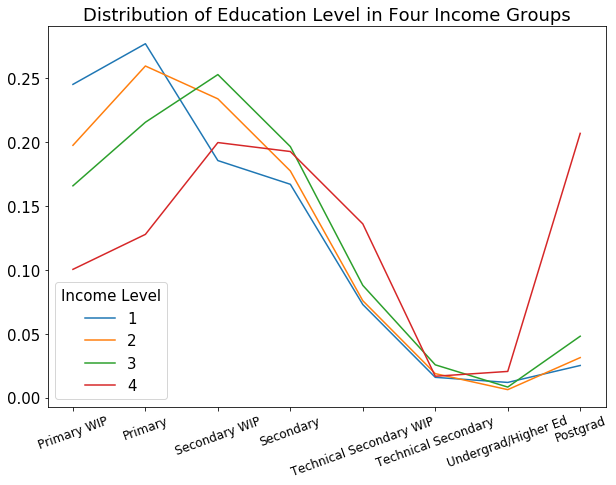

In [20]:
training['instlevel'] = training['instlevel1'] * 1 + training['instlevel2'] * 2 + training['instlevel3'] * 3 + training['instlevel4'] * 4 + training['instlevel5'] * 5 + training['instlevel6'] * 6 + training['instlevel7'] * 7 + training['instlevel8'] * 8 + training['instlevel9'] * 9
inst = pd.DataFrame()
for target in range(1,5):
    inst[target] = training.loc[training['Target'] == target,'instlevel'].value_counts().sort_index()
    total_samples = inst[target].sum()
    inst[target] = inst[target].apply(lambda x:x/total_samples)

fig, ax = plt.subplots(figsize=(10,7))
ax.set_title('Distribution of Education Level in Four Income Groups', fontsize=18)
# ax.set_xticks(['a','a','a','a','a','a','a','a'],x)
x_ticks_labels = ['No Edu','Primary WIP','Primary',
                  'Secondary WIP','Secondary',
                  'Technical Secondary WIP', 'Technical Secondary',
                 'Undergrad/Higher Ed', 'Postgrad']
# ax.set_xticks(x_ticks_labels)
ax.set_xticklabels(x_ticks_labels, rotation='vertical', fontsize=12)
inst.plot.line(ax=ax);
plt.xticks(rotation=20);
ax.legend(title='Income Level');
plt.savefig(os.getcwd() + '/plots/edu.png')

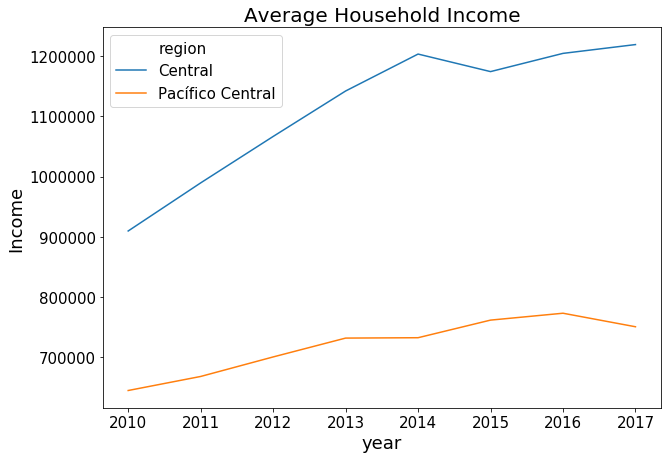

In [15]:
# hh_char[hh_char.Category == 'Income per household'][hh_char.region == 'Whole Costa Rica']
central_income = average_income_household.loc[(average_income_household.region == 'Central') | (average_income_household.region == 'Pacífico Central')]
# 
fig, ax = plt.subplots(figsize=(10,7))
sns.lineplot(x='year',y='Total',hue='region',data=central_income)
ax.set_title('Average Household Income', fontsize=20)
ax.set_ylabel('Income');
plt.savefig(os.getcwd() + '/plots/economy_income.png')

## Run google search on the key words related to poverty
In order to find more factors causing the country's poverty, we ran a google web search on a list of keywords related to poverty, and from its appearance frequency, figure out some hidden insights.

``The following cell will approximately 15 minutes to execute``

In [35]:
data=web_search('poverty level indicators in costa rican households',['sanitation', 'food', 'jobs', 'inequality',
                                                                      'education','infrastructure','government',
                                                                      'resources','employment','home','housing',
                                                                      'development','economic','background'
                                                                     ],20)

In [36]:
wordcloud_google2=WordCloud(max_words=35628500,background_color='rgba(255, 255, 255, 0)', mode="RGBA").generate_from_frequencies(data)

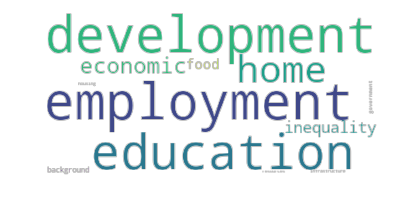

In [37]:
wordcloud_google2.to_file("google_search2.png")
    # show
plt.imshow(wordcloud_google2, interpolation="bilinear")
plt.axis("off")
plt.show()

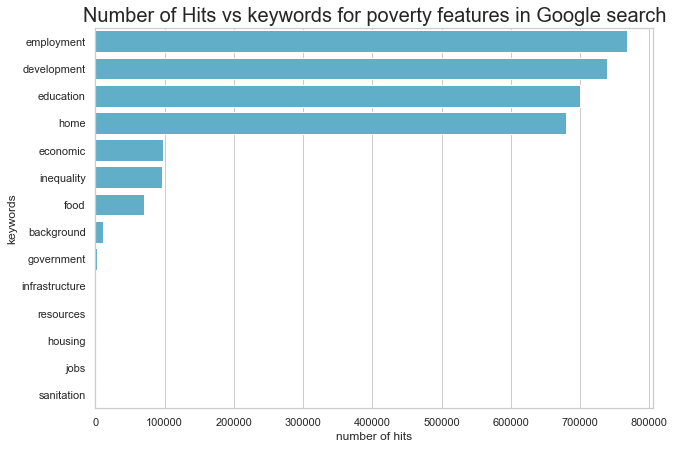

In [50]:
D2=pd.Series(data)
# D2=D2.drop(labels=['help','poor'])
D2=D2.sort_values(ascending=False)
# D2.plot.bar(rot=1)

fig, ax = plt.subplots(figsize=(10,7))
sns.set(style='whitegrid')
sns.barplot(x=D2[:],y=D2.keys(), color="#4fb7db")
ax.set_xlabel("number of hits")
ax.set_ylabel("keywords")
ax.set_title('Number of Hits vs keywords for poverty features in Google search',fontsize=20)
plt.savefig("keyword_hits.png")

## Google maps API companies heatmap plotting



In [52]:
import heat_map
years_locations = heat_map.load_companies_data()

In [53]:
heat_map.gmap_heat_map(years_locations[2012], '2012')

Figure(layout=FigureLayout(height='420px'))

# Twitter Data Scraping

(We are directly using the downloaded Twitter data since we are not uploading API Keys to Github)

Since we find interesting pattern on the income level line plots, and the key changing point on that plot corresponds to a presendential change, we utilized Twitter API to scrap data from both presents' twitter posts, utilize google translate API (API key not provided in the repo), to translate it into English, and ran through again to generate a workcloud to visualize the difference.

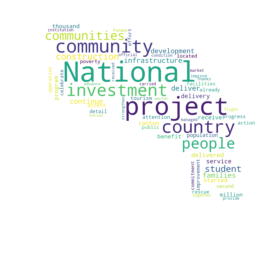

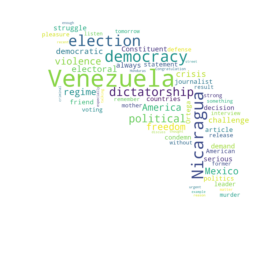

In [49]:
data1=cleaned_up_text(os.getcwd() + '/twitter_data/translated_Laura_ch_tweets.txt','Laura_Ch')
data2=cleaned_up_text(os.getcwd() + '/twitter_data/translated_CarlosAlvQ_tweets.txt','CarlosAlvQ')
data3=cleaned_up_text(os.getcwd() + '/twitter_data/translated_luisguillermosr_tweets.txt','luisguillermosr')
mask2=imr('costa_rica.jpg')
mask2=rgb2gray(mask2)
mask2[mask2>250]=255
mask2[mask2<250]=0
mask2=resize(mask2,(1200,1200))
wordcloud1 = WordCloud(max_words=35628500,mask=mask2,background_color='white').generate(data1)
wordcloud3 = WordCloud(max_words=356285,mask=mask2,background_color='white').generate(data3)
wordcloud_diff = find_diff(wordcloud1, wordcloud3)

makeImage_freq(dict(wordcloud_diff[0:60]),"luisguiller")
makeImage_freq(dict(wordcloud_diff[-60:]),"laura_ch")